# Final project: Data engineering and modelling

This notebook follows what we found in the EDA process conducted in a previous notebook and approaches both data engineering, model optimization and ensembling. 

Before running this notebook, the dependencies listed in the file requirements.txt should be installed in the environment. A computer with at least 16GB or RAM memory is needed, and at least 4 CPUs are desirable.

We start with importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import gc
import pickle
import data_io
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
from itertools import product, combinations

from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb





def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

Read input datasets into pandas dataframes

In [2]:
items_df=data_io.get_items_df()
item_categories_df=data_io.get_item_categories_df()
shops_df=data_io.get_shops_df()
sales_daily_df=data_io.get_sales_df()
test_df=data_io.get_test_df()

## Data cleansing and preparation

Remove outliers following EDA procedures. Aggregate sales by month, filtering out shops not included in the test data and mimic the test data distribution by including 0 sales shop-item pairs.

In [3]:
sales_daily_df = sales_daily_df.loc[(sales_daily_df.item_price < 100000) & 
                                    (sales_daily_df.item_cnt_day <= 1000) & 
                                    (sales_daily_df.item_price >=0)]

sales_daily_df = sales_daily_df[sales_daily_df['shop_id'].isin(test_df.shop_id.unique()) &
                               sales_daily_df['item_id'].isin(test_df.item_id.unique())]

sales_monthly_df = []
index_cols = ['shop_id','item_id','date_block_num']
for i in range(34):
    month_sales=sales_daily_df[sales_daily_df.date_block_num == i]
    sales_monthly_df.append(np.array(list(product(month_sales.shop_id.unique(), 
                                                  month_sales.item_id.unique(), [i])), dtype='int16'))
    
# Append test data as last month sales
test_df['date_block_num'] = 34
sales_monthly_df.append(test_df[index_cols])    
   
sales_monthly_df = pd.DataFrame(np.vstack(sales_monthly_df), columns=index_cols)
sales_monthly_df.head() 

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2574,0
2,59,2607,0
3,59,2614,0
4,59,2808,0


Parse and encode item category names as they come in two levels

In [4]:
le = preprocessing.LabelEncoder()

# The first word in categories is the generic category
item_categories_df['split'] = item_categories_df['item_category_name'].str.split('-')
item_categories_df['category_type'] = item_categories_df['split'].map(lambda x: x[0].strip())
item_categories_df['category_type'] = le.fit_transform(item_categories_df['category_type'])
item_categories_df['category_subtype'] = item_categories_df['split'].map(lambda x: ' '.join(x[1:]).strip()
                                                                         if len(x) > 1 else x[0].strip())
item_categories_df['category_subtype'] = le.fit_transform(item_categories_df['category_subtype'])
item_categories_df.drop(columns=['split'], inplace=True)

item_categories_df.head()

,item_category_name,item_category_id,category_type,category_subtype
0,PC - Гарнитуры/Наушники,0,0,31
1,Аксессуары - PS2,1,1,11
2,Аксессуары - PS3,2,1,12
3,Аксессуары - PS4,3,1,13
4,Аксессуары - PSP,4,1,15


Parse and encode shop names as the first word depicts the city

In [5]:
shops_df['split'] = shops_df['shop_name'].str.split(' ')
shops_df['city_name'] = shops_df['split'].map(lambda x: x[0].strip())
shops_df['city_code'] = le.fit_transform(shops_df['city_name'])
shops_df['short_shop_name'] = shops_df['split'].map(lambda x: ' '.join(x[1:]).strip())

shops_df.drop(columns=['split'], inplace=True)
shops_df.head()

,shop_name,shop_id,city_name,city_code,short_shop_name
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0,"Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0,"ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1,"ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2,"ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3,"ТЦ ""Волга Молл"""


Compute TF-IDF vectors for item names as item names this may be important for sale predictions

Join sales with shop and item category descriptions

In [6]:
all_data_df = pd.merge(sales_monthly_df, shops_df, on=['shop_id'], how='left')
all_data_df = pd.merge(all_data_df, items_df, on=['item_id'], how='left')
all_data_df = pd.merge(all_data_df, item_categories_df, on=['item_category_id'], how='left')



all_data_df.head()

,shop_id,item_id,date_block_num,shop_name,city_name,city_code,short_shop_name,item_name,item_category_id,item_category_name,category_type,category_subtype
0,59,22154,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,11,1
1,59,2574,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,13,4
2,59,2607,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства,13,4
3,59,2614,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",DEPECHE MODE Violator,55,Музыка - CD локального производства,13,4
4,59,2808,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,8,57


## Feature engineering

The set of features that we have extracted to create the models come from the following sources:

* Lagged target values for shop/items and mean lagged target vales for shop, items and categories
* Interactions between lagged features
* Month when the sale is happening
* Elapsed time since the product is in the market or since its last sale
* Statistics on how sales on shops and categories behave when new products are introduced
* Text features computed from item names

### Get target
Compute target values as a monthly aggregation of shop-item sales

In [7]:
all_data_df.drop(columns=['shop_name','city_name','item_name','item_category_name',
                          'short_shop_name'], inplace=True)

group = sales_daily_df.groupby(index_cols,as_index=False)['item_cnt_day'].sum()
group.rename(columns={'item_cnt_day':'target'}, inplace=True)
all_data_df = pd.merge(all_data_df, group, on=index_cols, how='left')

# Clip target in range (0,20) as test dataset is clipped in the same way
all_data_df['target'].clip(0,20, inplace=True)

### Lagged features and mean encodings

Now we move to derived features. We compute the aggregated sales for every shop, city, item, category, subcategory, shop-item and shop-category. The aggregated shop-item sales for the current month will act as the target. Then, we will shift the values in order to get lagged features.

In [8]:
# Shop
merge_cols=['shop_id','date_block_num']
group = all_data_df.groupby(merge_cols,as_index=False)['target'].mean()
group.rename(columns={'target':'target_shop'}, inplace=True)
all_data_df = pd.merge(all_data_df, group, on=merge_cols, how='left')

# Item
merge_cols=['item_id','date_block_num']
group = all_data_df.groupby(merge_cols,as_index=False)['target'].mean()
group.rename(columns={'target':'target_item'}, inplace=True)
all_data_df = pd.merge(all_data_df, group, on=merge_cols, how='left')

# Item category
merge_cols=['category_type','date_block_num']
group = all_data_df.groupby(merge_cols,as_index=False)['target'].mean()
group.rename(columns={'target':'target_category'}, inplace=True)
all_data_df = pd.merge(all_data_df, group, on=merge_cols, how='left')

# Item subcategory
merge_cols=['category_subtype','date_block_num']
group = all_data_df.groupby(merge_cols,as_index=False)['target'].mean()
group.rename(columns={'target':'target_subcategory'}, inplace=True)
all_data_df = pd.merge(all_data_df, group, on=merge_cols, how='left')

# Shop-category
merge_cols=['shop_id','item_category_id','date_block_num']
group = all_data_df.groupby(merge_cols,as_index=False)['target'].mean()
group.rename(columns={'target':'target_shop_category'}, inplace=True)
all_data_df = pd.merge(all_data_df, group, on=merge_cols, how='left')


all_data_df.head()

,shop_id,item_id,date_block_num,city_code,item_category_id,category_type,category_subtype,target,target_shop,target_item,target_category,target_subcategory,target_shop_category
0,59,22154,0,31,37,11,1,1.0,2.292929,1.333333,1.914331,1.701068,1.090909
1,59,2574,0,31,55,13,4,2.0,2.292929,3.652174,1.579821,1.612662,1.346154
2,59,2607,0,31,55,13,4,NaN,2.292929,1.384615,1.579821,1.612662,1.346154
3,59,2614,0,31,55,13,4,NaN,2.292929,1.230769,1.579821,1.612662,1.346154
4,59,2808,0,31,30,8,57,15.0,2.292929,15.333333,6.176309,6.132855,6.625000


Following. We lag the target at peridos [1,2,3,6], as well as lagged mean encodings for shops, items, categories, etc.

In [9]:
# List of columns that we will use to create lags
lag_cols = ['target','target_shop','target_item','target_category', 'target_subcategory','target_shop_category']

shift_range = [1, 2, 3, 6]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data_df[index_cols +lag_cols].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    all_data_df = pd.merge(all_data_df, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

all_data_df.head()

,shop_id,item_id,date_block_num,city_code,item_category_id,category_type,category_subtype,target,target_shop,target_item,...,target_item_lag_3,target_category_lag_3,target_subcategory_lag_3,target_shop_category_lag_3,target_lag_6,target_shop_lag_6,target_item_lag_6,target_category_lag_6,target_subcategory_lag_6,target_shop_category_lag_6
0,59,22154,0,31,37,11,1,1.0,2.292929,1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2574,0,31,55,13,4,2.0,2.292929,3.652174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2607,0,31,55,13,4,0.0,2.292929,1.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2614,0,31,55,13,4,0.0,2.292929,1.230769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2808,0,31,30,8,57,15.0,2.292929,15.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature selection

Below we compute advanced features that generate a large number of columns which 
we can't deal with given memory restrictions. In order to improve this situation, we perform feature selection via the application of LightGBM to get the feature importances and select the most relevant. To do that, we define the following function

In [10]:
def select_features(X_train, y_train, num_features):
    
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1 
              }


    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    
    print('Plot feature importances...')
    fig=plt.figure(figsize=(10,14))
    ax = lgb.plot_importance(lgb_model, figsize=(10, 30))
    plt.show()
    
    feature_importances=list(zip(lgb_model.feature_name(), lgb_model.feature_importance()))
    selected_features=[x[0] 
                           for x in sorted(feature_importances, key=lambda x: x[1], reverse=True)[:num_features]]


    del lgb_model


    return selected_features
    
    
    
    

### Interactions

The interactions between lagged features might be important for trend detection. We compute them and then we use LightGBM to select the most relevant

Plot feature importances...


<Figure size 720x1008 with 0 Axes>

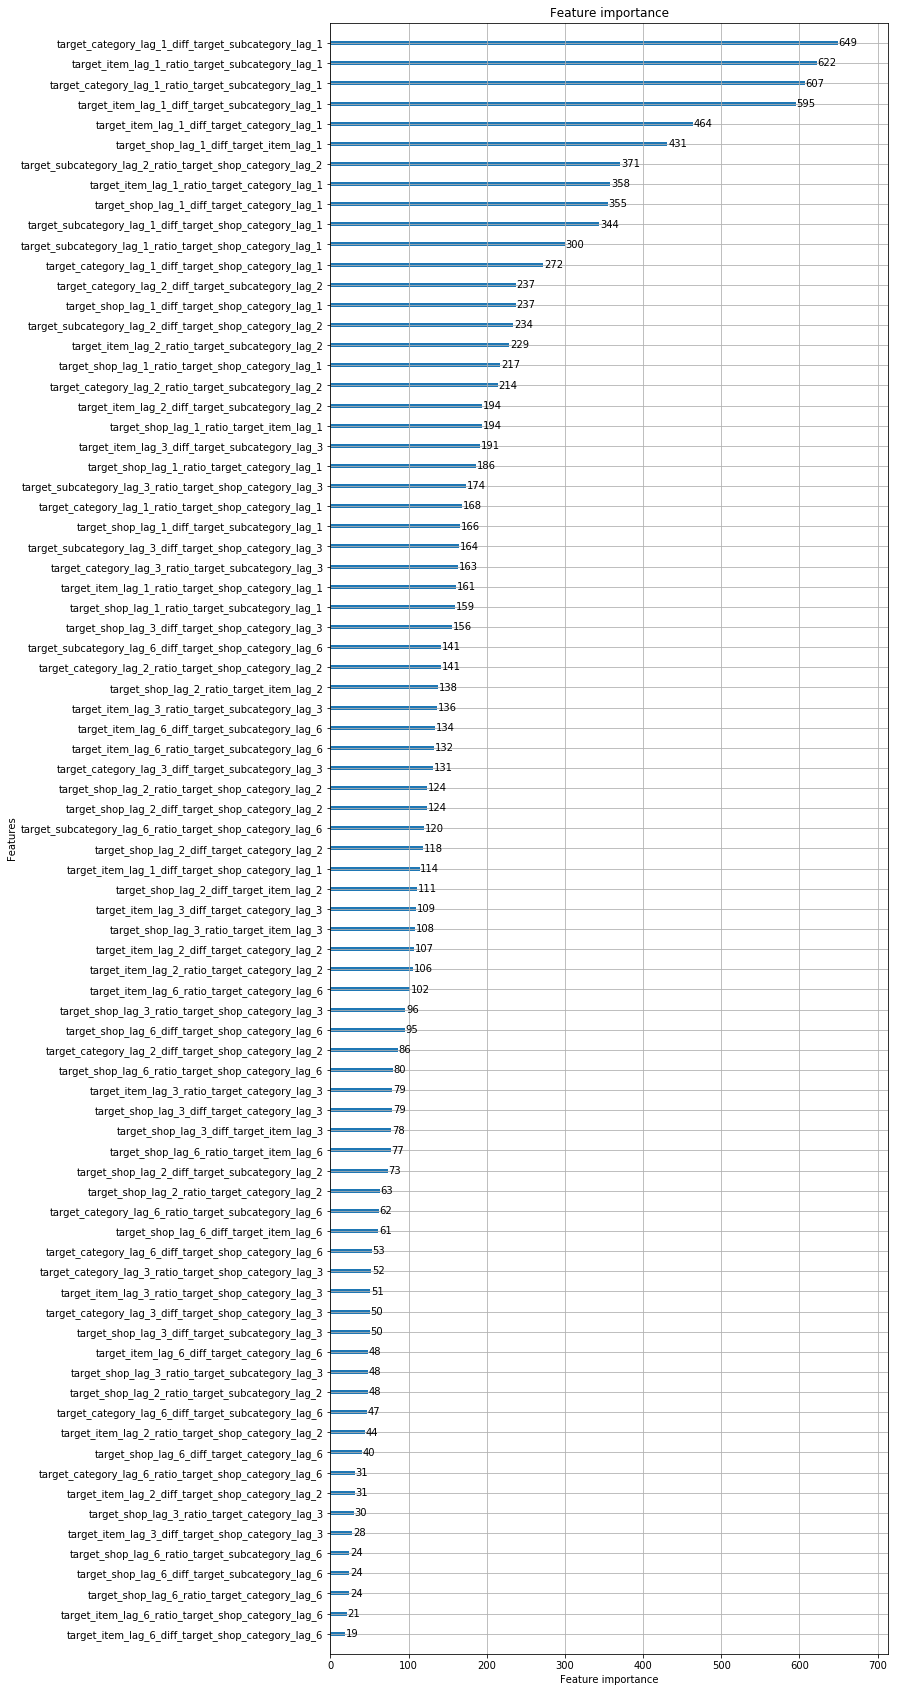

In [11]:
interactions_df=pd.DataFrame(all_data_df[['date_block_num','target']])
eps=1e-5
all_lag_cols=[]
for col1, col2 in combinations(lag_cols[1:],2):
    for lag in shift_range:
        lag_col1='{0}_lag_{1}'.format(col1, lag)
        lag_col2='{0}_lag_{1}'.format(col2, lag)
        
        diff_col=lag_col1+'_diff_'+lag_col2
        ratio_col=lag_col1+'_ratio_'+lag_col2
        
        interactions_df[diff_col]=all_data_df[lag_col1]-all_data_df[lag_col2]
        interactions_df[ratio_col]=all_data_df[lag_col1]/(all_data_df[lag_col2]+eps)
        
        all_lag_cols.append(diff_col)
        all_lag_cols.append(ratio_col)
        

X_train=interactions_df[interactions_df.date_block_num<33][all_lag_cols]
y_train=all_data_df[all_data_df.date_block_num<33]['target']


selected_interactions=select_features(X_train, y_train, 10)
for feature in selected_interactions:
    all_data_df[feature]=interactions_df[feature]

del X_train
del y_train

### Special features
Special features like month number and number of days in the month that can help with seasonality

In [12]:
# Don't use old data from year 2013
all_data_df = all_data_df[all_data_df['date_block_num'] >=12]
all_data_df=downcast_dtypes(all_data_df)
gc.collect()
all_data_df['month'] = all_data_df['date_block_num'] % 12

The most difficult targets are the predictions for new items. To help the model in order to focus on those, we compute the time that the item has been on the market. We also compute the mean target for new products in every shop or product category.

In [13]:
first_item_sale=all_data_df.groupby(['item_id'])['date_block_num'].min()
all_data_df['elapsed_first_sale']=all_data_df['date_block_num']-all_data_df['item_id'].map(first_item_sale)

last_item_sale=all_data_df[all_data_df.target>0].groupby(['item_id'])['date_block_num'].max()
all_data_df['elapsed_last_sale']=all_data_df['date_block_num']-all_data_df['item_id'].map(last_item_sale)
all_data_df['elapsed_last_sale'].clip(lower=0, inplace=True)


# Do this excluding validation and test data
new_item_sales=all_data_df[all_data_df.elapsed_first_sale == 0]


# Mean target for new items in every shop
mean_target_shop_new=new_item_sales.groupby('shop_id')['target'].mean()
all_data_df['mean_target_shop_newitem']=all_data_df['shop_id'].map(mean_target_shop_new)

# Mean target for new items in every product category and subcategory
mean_target_cat_new=new_item_sales.groupby('category_type')['target'].mean()
all_data_df['mean_target_cat_newitem']=all_data_df['category_type'].map(mean_target_cat_new)

mean_target_subcat_new=new_item_sales.groupby('category_subtype')['target'].mean()
all_data_df['mean_target_subcat_newitem']=all_data_df['category_subtype'].map(mean_target_subcat_new)

# Mean target for new items in every shop-category and shop-subcategory
mean_target_shopcat_new=new_item_sales.groupby(['shop_id','category_type'], as_index=False)['target'].mean()
mean_target_shopcat_new.rename(columns={'target':'mean_target_shopcat_newitem'}, inplace=True)
all_data_df=pd.merge(all_data_df, mean_target_shopcat_new, on=['shop_id','category_type'], how='left')

mean_target_shopsubcat_new=new_item_sales.groupby(['shop_id','category_subtype'], as_index=False)['target'].mean()
mean_target_shopsubcat_new.rename(columns={'target':'mean_target_shopsubcat_newitem'}, inplace=True)
all_data_df=pd.merge(all_data_df, mean_target_shopsubcat_new, on=['shop_id','category_subtype'], how='left')



del mean_target_shop_new
del mean_target_cat_new
del mean_target_shopcat_new

all_data_df.head()


,shop_id,item_id,date_block_num,city_code,item_category_id,category_type,category_subtype,target,target_shop,target_item,...,target_shop_lag_1_diff_target_category_lag_1,target_subcategory_lag_1_diff_target_shop_category_lag_1,month,elapsed_first_sale,elapsed_last_sale,mean_target_shop_newitem,mean_target_cat_newitem,mean_target_subcat_newitem,mean_target_shopcat_newitem,mean_target_shopsubcat_newitem
0,55,492,12,28,76,15,33,20.0,4.349057,20.0,...,1.024872,0.000000,0,0,0.0,0.365098,0.227573,0.047273,0.926316,1.918033
1,55,504,12,28,31,8,63,7.0,4.349057,7.0,...,-0.186130,0.885667,0,0,0.0,0.365098,1.697089,0.127653,2.508265,5.088050
2,55,508,12,28,31,8,63,3.0,4.349057,3.0,...,-0.186130,0.885667,0,0,0.0,0.365098,1.697089,0.127653,2.508265,5.088050
3,55,515,12,28,31,8,63,6.0,4.349057,6.0,...,-0.186130,0.885667,0,0,0.0,0.365098,1.697089,0.127653,2.508265,5.088050
4,55,539,12,28,78,15,47,2.0,4.349057,2.0,...,1.024872,0.000000,0,0,0.0,0.365098,0.227573,0.029261,0.926316,1.163265


### Text based features

Last, but not least, we add features based on item names. Concretely, we compute TF-IDF vectors, removing stopwords, rare and too frequent words. Then, we apply TruncatedSVD to reduce the dimenstionality of the resultant vectors. This helps to reduce computational burden and to remove some noise in the way. Finally we select the prominent SVD components by LightGBM so we work only with 20 textual features

In [14]:
stopWords = stopwords.words('russian')

vectorizer=TfidfVectorizer(max_df=0.8, min_df=2, stop_words=stopWords, ngram_range=(1,2), max_features=300,
                           encoding='koi8r')
X=vectorizer.fit_transform(items_df.item_name)

In [15]:
num_components=100
svd = TruncatedSVD(num_components)
        
        
X_svd = svd.fit_transform(X)


explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 79%


Plot feature importances...


<Figure size 720x1008 with 0 Axes>

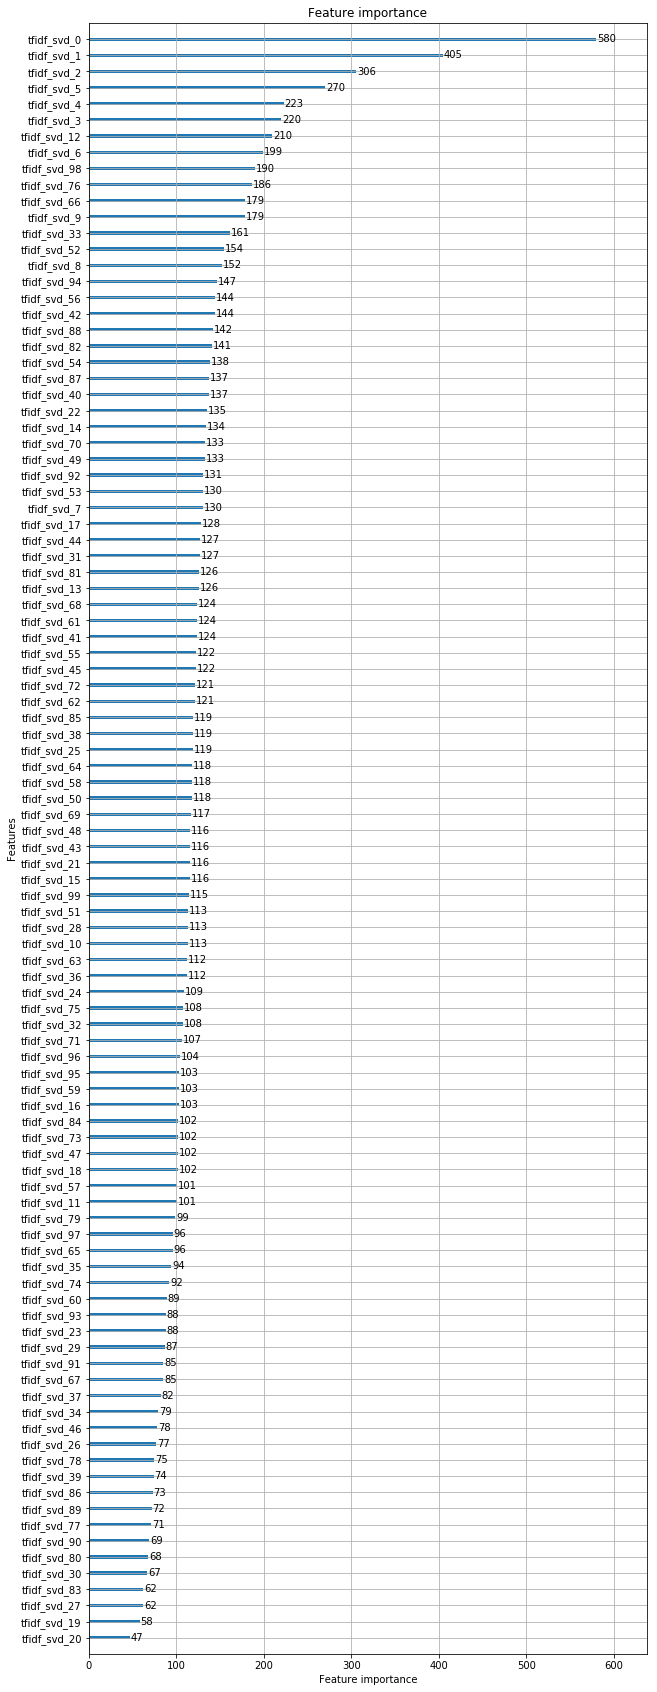

In [16]:
svd_cols=['tfidf_svd_{}'.format(i) for i in range(0,num_components)]
svd_df=pd.DataFrame(X_svd, columns=svd_cols)

items_svd_df=pd.concat([items_df['item_id'], svd_df], axis=1)

items_svd_df.set_index('item_id')
items_svd_df=downcast_dtypes(items_svd_df)

train_items=all_data_df[all_data_df.date_block_num<33][['item_id']]
X_train=train_items.merge(items_svd_df, on='item_id', how='left').fillna(0)
X_train.drop(columns=['item_id'], inplace=True)
y_train=all_data_df[all_data_df.date_block_num<33]['target']

selected_text_features=select_features(X_train, y_train, 20)


Join item features with monthly sales

In [17]:
selected_items_svd_df=items_svd_df[['item_id']+selected_text_features]
selected_items_svd_df.set_index('item_id')
all_data_df=all_data_df.merge(selected_items_svd_df, on='item_id', how='left')

del X_train
del y_train


Fill NaNs with zeros, downcast and save sales to disk. Filling with zeros makes sense in this case as we can assume that when a sale is not present means that there are 0 sales

In [18]:
all_data_df.fillna(0, inplace=True)
all_data_df=downcast_dtypes(all_data_df)

# all_data_df.to_hdf(path_or_buf='alldata.hdf', key='all_data')

all_data_df.head()

,shop_id,item_id,date_block_num,city_code,item_category_id,category_type,category_subtype,target,target_shop,target_item,...,tfidf_svd_9,tfidf_svd_66,tfidf_svd_33,tfidf_svd_52,tfidf_svd_8,tfidf_svd_94,tfidf_svd_42,tfidf_svd_56,tfidf_svd_88,tfidf_svd_82
0,55,492,12,28,76,15,33,20.0,4.349057,20.0,...,-0.136187,0.005263,-0.087074,-0.002067,0.189621,0.001376,-0.002644,0.004249,-0.011924,-0.002735
1,55,504,12,28,31,8,63,7.0,4.349057,7.0,...,-0.160139,-0.001266,-0.048199,-0.007676,0.248277,-0.012930,0.004436,0.006396,-0.008122,-0.007002
2,55,508,12,28,31,8,63,3.0,4.349057,3.0,...,-0.177746,0.000251,-0.027661,-0.007057,0.279091,-0.015242,0.001904,0.013641,-0.004436,-0.003862
3,55,515,12,28,31,8,63,6.0,4.349057,6.0,...,-0.177746,0.000251,-0.027661,-0.007057,0.279091,-0.015242,0.001904,0.013641,-0.004436,-0.003862
4,55,539,12,28,78,15,47,2.0,4.349057,2.0,...,-0.168286,-0.049798,-0.040122,-0.015501,0.257726,0.026248,-0.014063,0.015118,0.056811,-0.007109


# Hyper-parameter optimization

For hyperparameter tuning, we need to check the models performance on a validation dataset, labeled with the count of items sold per shop for a given month, similar to the test dataset used to calculate the leaderboard scores. In this case, we can use the data from the last month in the provided data, October 2015 as validation and the rest of the months (from 2014 as we worked with lagged features) as training data.

Below we show the train/test split and the tuning for the models. The tuning has been done manually, so only the best found parameters are shown.

We have also been extracting which are the most useful features as shown below. Interactions did not shown to be useful. On the other hand, including the item identifier makes a difference, which is a little frustrating. It seems that some information is embedded in the identifiers but can't be found in the rest of features. 


In [19]:
# all_data_df=pd.read('alldata.hdf')

train_df= all_data_df[all_data_df.date_block_num<33]
validation_df=all_data_df[all_data_df.date_block_num==33]
test_df = all_data_df[all_data_df.date_block_num == 34]

features=['item_id','month','elapsed_first_sale','elapsed_last_sale',
         'mean_target_shop_newitem','mean_target_cat_newitem',
          'mean_target_subcat_newitem', 'mean_target_shopcat_newitem',
         'mean_target_shopsubcat_newitem']


for lag_col in lag_cols:
    for lag in shift_range:
        features.append('{0}_lag_{1}'.format(lag_col, lag))

# features+=selected_interactions
features+=selected_text_features 

X_train=train_df[features]
y_train=train_df['target']


X_val=validation_df[features]
y_val=validation_df['target']

X_test=test_df[features]


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)



(2058899, 53)
(166110, 53)
(214200, 53)


We launch the modeling wih LightGBM, since it is fast and expressive so we can quickly find issues in our features

Train score: 0.9315544947778981, val score: 0.9005450433874573
Plot feature importances...


<Figure size 720x2160 with 0 Axes>

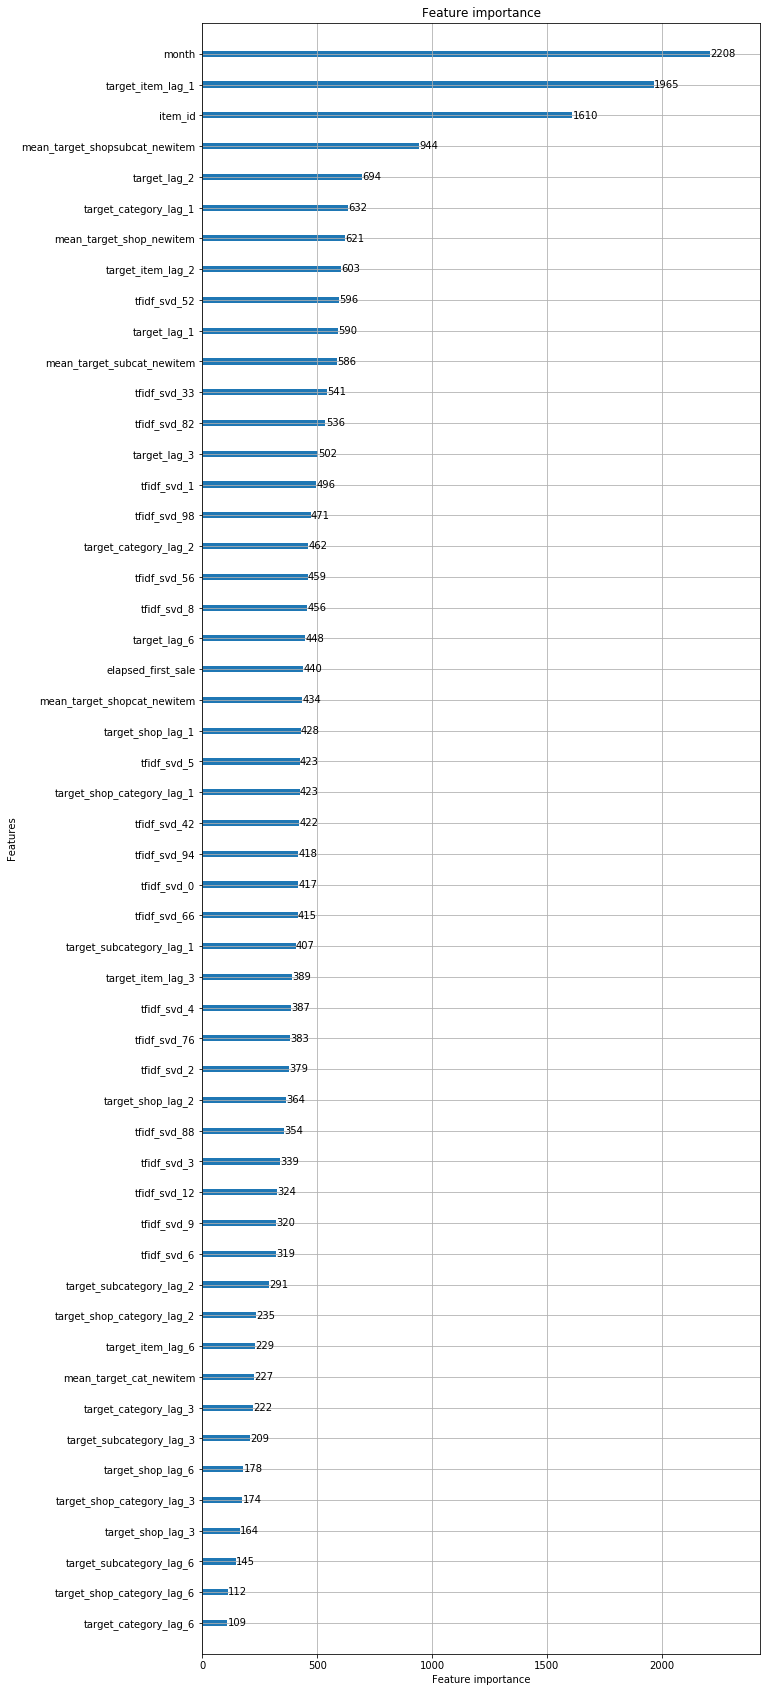

In [20]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**8,
               'bagging_freq':1
              }


lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)



y_pred_train=lgb_model.predict(X_train)
train_score=np.sqrt(mean_squared_error(y_train, y_pred_train))
  
lgm_pred_val=lgb_model.predict(X_val)
val_score=np.sqrt(mean_squared_error(y_val, lgm_pred_val))

print('Train score: {0}, val score: {1}'.format(train_score, val_score))
    
print('Plot feature importances...')
fig=plt.figure(figsize=(10,30))
ax = lgb.plot_importance(lgb_model, figsize=(10, 30))
plt.show()



Following, we fit the data with XGBoost

In [21]:
xgb_params={'max_depth':8,
           'n_estimators':40,
           'min_child_weight':6,
           'colsample_bytree':0.8,
           'subsample':0.8,
           'eta':0.3,
           'n_jobs': 4}

xgb_model = XGBRegressor(**xgb_params)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)],
    
    verbose=True)

y_pred_train=xgb_model.predict(X_train)
train_score=np.sqrt(mean_squared_error(y_train, y_pred_train))
  
xgb_pred_val=xgb_model.predict(X_val)
val_score=np.sqrt(mean_squared_error(y_val, xgb_pred_val))

print('Train score: {0}, val score: {1}'.format(train_score, val_score))

[0]	validation_0-rmse:1.50587	validation_1-rmse:1.18236
[1]	validation_0-rmse:1.43605	validation_1-rmse:1.13326
[2]	validation_0-rmse:1.3752	validation_1-rmse:1.09169
[3]	validation_0-rmse:1.32321	validation_1-rmse:1.05663
[4]	validation_0-rmse:1.27679	validation_1-rmse:1.02757
[5]	validation_0-rmse:1.23694	validation_1-rmse:1.00755
[6]	validation_0-rmse:1.20423	validation_1-rmse:0.986814
[7]	validation_0-rmse:1.1756	validation_1-rmse:0.969412
[8]	validation_0-rmse:1.15099	validation_1-rmse:0.955518
[9]	validation_0-rmse:1.12889	validation_1-rmse:0.944134
[10]	validation_0-rmse:1.10974	validation_1-rmse:0.935665
[11]	validation_0-rmse:1.09463	validation_1-rmse:0.928372
[12]	validation_0-rmse:1.08051	validation_1-rmse:0.921482
[13]	validation_0-rmse:1.06869	validation_1-rmse:0.9161
[14]	validation_0-rmse:1.05855	validation_1-rmse:0.912136
[15]	validation_0-rmse:1.04844	validation_1-rmse:0.908079
[16]	validation_0-rmse:1.04013	validation_1-rmse:0.901452
[17]	validation_0-rmse:1.03119	val

Next, we fit a Random Forest, for the sake of model variety

In [22]:
rf_params={'max_depth':11,
           'n_estimators':35,
           'n_jobs': 4,
            'verbose':0}

rf_model = RandomForestRegressor(**rf_params)

rf_model.fit(
    X_train, 
    y_train)

y_pred_train=rf_model.predict(X_train)
train_score=np.sqrt(mean_squared_error(y_train, y_pred_train))
  
rf_pred_val=rf_model.predict(X_val)
val_score=np.sqrt(mean_squared_error(y_val, rf_pred_val))

print('Train score: {0}, val score: {1}'.format(train_score, val_score))

[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 10.7min finished
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    3.2s finished


Train score: 0.9488472656627248, val score: 0.9062997832522964


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.2s finished


# Ensembling

We perform stacking with a simple Linear Regression metamodel. Unfortunately, given time constrains, we could not include all models that we would like. We follow the Hold-Out produre taught by Mario in the course exercise 

In [23]:
from sklearn.metrics import r2_score

dates = all_data_df['date_block_num']
dates_train = dates[dates <  33]
dates_test  = dates[dates == 33]

dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 3])

first_index=dates_train_level2.index[0]

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    # Prepare data
    X_train_block = all_data_df.loc[dates <  cur_block_num][features]
    X_test_block =  all_data_df.loc[dates == cur_block_num][features]
    y_train_block = all_data_df.loc[dates <  cur_block_num, 'target'].values
    y_test_block =  all_data_df.loc[dates == cur_block_num, 'target'].values
    
    
    # Fit LightGBM
    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train_block, label=y_train_block), 100)
    pred_lgb_block = lgb_model.predict(X_test_block)

    print('MSE for LightGBM is %f' % np.sqrt(mean_squared_error(y_test_block, pred_lgb_block)))
    
    # Fit XGBoost
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train_block, y_train_block, eval_metric="rmse")
    pred_xgb_block = xgb_model.predict(X_test_block)
    
    print('MSE for XGBoost is %f' % np.sqrt(mean_squared_error(y_test_block, pred_xgb_block)))
    
    # Fit Random Forest
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train_block, y_train_block)
    pred_rf_block = rf_model.predict(X_test_block)
    
    print('MSE for Random Forest is %f' % np.sqrt(mean_squared_error(y_test_block, pred_rf_block)))
    
    cur_block_dates=dates_train_level2[dates_train_level2 == cur_block_num].index-first_index
    X_train_level2[cur_block_dates]= np.c_[pred_lgb_block, pred_xgb_block, pred_rf_block]

27
MSE for LightGBM is 1.058414
MSE for XGBoost is 1.070220


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  5.8min finished
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.1s finished


MSE for Random Forest is 1.072862
28
MSE for LightGBM is 0.941093
MSE for XGBoost is 0.951179


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.2s finished


MSE for Random Forest is 0.964564
29
MSE for LightGBM is 0.948944
MSE for XGBoost is 0.921558


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  7.2min finished
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.1s finished


MSE for Random Forest is 0.968611
30
MSE for LightGBM is 0.801513
MSE for XGBoost is 0.807361


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  8.3min finished
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.2s finished


MSE for Random Forest is 0.822325
31
MSE for LightGBM is 0.872386
MSE for XGBoost is 0.876189


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  8.6min finished
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.3s finished


MSE for Random Forest is 0.895278
32
MSE for LightGBM is 0.948796
MSE for XGBoost is 0.968810


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 10.1min finished


MSE for Random Forest is 0.984840


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.2s finished


In [25]:
ensembling_lr= LinearRegression()
ensembling_lr.fit(X_train_level2, y_train_level2)

train_preds = ensembling_lr.predict(X_train_level2)
mse_train_stacking = np.sqrt(mean_squared_error(y_train_level2, train_preds))

X_val_level2 = np.c_[lgm_pred_val, xgb_pred_val, rf_pred_val]
test_preds = ensembling_lr.predict(X_val_level2)
mse_test_stacking = np.sqrt(mean_squared_error(y_val, test_preds))

print('Train MSE for stacking is %f' % mse_train_stacking)
print('Val  MSE for stacking is %f' % mse_test_stacking)

Train MSE for stacking is 0.927022
Test  MSE for stacking is 0.893092


In [26]:
ensembling_lr.coef_

array([ 0.75624774,  0.38064225, -0.13522174])

# Final training with all data

Fit first level models with all training data

In [28]:
# Train data now includes months until October 2015
X_train_all=pd.concat([X_train, X_val])
y_train_all=pd.concat([y_train, y_val])

# Train LightGBM with all data
lgb_model_all = lgb.train(lgb_params, lgb.Dataset(X_train_all, label=y_train_all), 100)

# Save to disk
pickle.dump(lgb_model_all, open('lgb.pkl', 'wb'))
print("Trained LightGBM")

# Train XGBoost with all data
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train_all, y_train_all, eval_metric="rmse")

# Save to disk
pickle.dump(xgb_model, open('xgb.pkl', 'wb'))
print("Trained XGBoost")

# Train RandomFores with all data
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train_all, y_train_all)

# Save to disk
pickle.dump(rf_model, open('rf.pkl', 'wb'))

print("Trained Random Forest")


Trained LightGBM
Trained XGBoost
Trained Random Forest


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 11.9min finished


Train second level model with all data

In [32]:
X_train_level2_all=np.vstack([X_train_level2,X_val_level2])
y_train_level2_all = pd.concat([y_train_level2, y_val])

ensembling_lr_all= LinearRegression()
ensembling_lr_all.fit(X_train_level2_all, y_train_level2_all)

train_preds = ensembling_lr_all.predict(X_train_level2_all)
mse_train_stacking = np.sqrt(mean_squared_error(y_train_level2_all, train_preds))

print('Train MSE for stacking is %f' % mse_train_stacking)

# Save to disk
pickle.dump(ensembling_lr_all, open('ensemble_lr.pkl','wb'))

Train MSE for stacking is 0.921040


# Prediction of test dataset

In [34]:
lgb_model=pickle.load(open('lgb.pkl','rb'))
xgb_model=pickle.load(open('xgb.pkl','rb'))
rf_model=pickle.load(open('rf.pkl','rb'))
ensembling_lr=pickle.load(open('ensemble_lr.pkl','rb'))

lgb_test=lgb_model_all.predict(X_test)
xgb_test=xgb_model.predict(X_test)
rf_test=rf_model.predict(X_test)

X_test_level2 = np.c_[lgb_test, xgb_test, rf_test]
test_preds = ensembling_lr.predict(X_test_level2)

predictions=pd.DataFrame(test_preds).clip(0,20)
predictions.index.name='ID'
predictions.columns=['item_cnt_month']
predictions.to_csv('submission.csv',index=True)




[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.2s finished
